In [45]:
import torch
import torchvision
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [46]:
class CNN(torch.nn.Module):
    def __init__(self, number_of_channels, number_of_classes=10):
        super(CNN, self).__init__()
        self.conv_01 = torch.nn.Conv2d(
            in_channels = number_of_channels,
            out_channels = 20,
            kernel_size = (5, 5)
        )
        self.relu_01 = torch.nn.ReLU()
        self.max_pool_01 = torch.nn.MaxPool2d(
            kernel_size=(2, 2), stride=(2, 2)
        )
        self.conv_02 = torch.nn.Conv2d(
            in_channels=20,
            out_channels=50,
            kernel_size=(5, 5)
        )
        self.relu_02 = torch.nn.ReLU()
        self.max_pool_02 = torch.nn.MaxPool2d(
            kernel_size=(2, 2), stride=(2, 2)
        )
        self.fully_connected_01 = torch.nn.Linear(in_features=800, out_features=500)
        self.relu_03 = torch.nn.ReLU()
        
        self.fully_connected_02 = torch.nn.Linear(in_features=500, out_features=number_of_classes)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.conv_01(x)
        x = self.relu_01(x)
        x = self.max_pool_01(x)
        
        x = self.conv_02(x)
        x = self.relu_02(x)
        x = self.max_pool_02(x)
        
        x = torch.flatten(x, 1)
        x = self.fully_connected_01(x)
        x = self.relu_03(x)
        
        x = self.fully_connected_02(x)
        output = self.log_softmax(x)
        
        return output

In [47]:
init_learning_rate = 1e-3
batch_size = 64
epochs = 10

train_split = 0.75
validation_split = 0.25

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
import numpy as np

print(f"Loading the KMNIST dataset...")
train_data = torchvision.datasets.KMNIST(root="data",
                train=False, download=True, transform=torchvision.transforms.ToTensor()
)
test_data = torchvision.datasets.KMNIST(root="data", 
                train=False, download=True, transform=torchvision.transforms.ToTensor()
)

print(f"Generating the train/validation split")
number_of_train_samples = int(len(train_data) * train_split)
number_of_validation_samples = int(len(train_data) * validation_split)
(train_data, validation_data) = random_split(train_data,
                                             [number_of_train_samples, number_of_validation_samples],
                                             generator=torch.Generator().manual_seed(42))

Loading the KMNIST dataset...
Generating the train/validation split


In [49]:
training_data_loader = torch.utils.data.DataLoader(
    train_data, shuffle=True, batch_size=batch_size
)
validation_data_loader = torch.utils.data.DataLoader(
    validation_data, batch_size=batch_size
)
test_data_loader = DataLoader(test_data, batch_size=batch_size)

train_steps = len(training_data_loader.dataset) // batch_size
validation_steps = len(validation_data_loader.dataset) // batch_size

In [53]:
model = CNN(
    number_of_channels=1,
    number_of_classes = len(train_data.dataset.classes)
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(), lr=init_learning_rate
)
criterion = torch.nn.NLLLoss()

H = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for e in range(0, epochs):
    model.train()
    
    total_train_loss = 0
    total_validation_loss = 0
    
    train_correct = 0
    validation_correct = 0
    
    for(x, y) in training_data_loader:
        (x, y) = (x.to(device), y.to(device))
        
        prediction = model(x)
        loss = criterion(prediction, y)
        
        # zero ut the gradients, calculate/perform the backprogation step and update the weights
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss
        train_correct += (prediction.argmax(1)==y).type(torch.float).sum().item()
    
    with torch.no_grad():
        model.eval()
        
        for (x, y) in validation_data_loader:
            (x, y) = (x.to(device), y.to(device))
            
            prediction = model(x)
            loss = criterion(prediction, y)
            total_validation_loss += loss
            
            validation_correct += (prediction.argmax(1) == y).type(
                torch.float).sum().item()
    
    average_train_loss = total_train_loss / train_steps
    average_validation_loss = total_validation_loss / validation_steps
    
    train_correct = train_correct / len(training_data_loader.dataset)
    validation_correct = validation_correct / len(validation_data_loader.dataset)
    
    H["train_loss"].append(average_train_loss.cpu().detach().numpy())
    H["train_acc"].append(train_correct)
    H["val_loss"].append(average_train_loss.cpu().detach().numpy())
    H["val_acc"].append(validation_correct)
    
    print(f"[INFO] Epoch: {e+1}/{epochs}")
    print(f"Train loss: {average_train_loss:.6f}, Train accuracy: {train_correct:.4f}")
    print(f"Validation loss: {average_validation_loss:.6f}, Validation accuracy: {validation_correct:.4f}")

[INFO] Epoch: 1/10
Train loss: 1.197438, Train accuracy: 0.6169
Validation loss: 0.696176, Validation accuracy: 0.7832
[INFO] Epoch: 2/10
Train loss: 0.516110, Train accuracy: 0.8363
Validation loss: 0.410207, Validation accuracy: 0.8820
[INFO] Epoch: 3/10
Train loss: 0.313744, Train accuracy: 0.9009
Validation loss: 0.316267, Validation accuracy: 0.9080
[INFO] Epoch: 4/10
Train loss: 0.218301, Train accuracy: 0.9335
Validation loss: 0.292367, Validation accuracy: 0.9132
[INFO] Epoch: 5/10
Train loss: 0.139462, Train accuracy: 0.9567
Validation loss: 0.243310, Validation accuracy: 0.9304
[INFO] Epoch: 6/10
Train loss: 0.095866, Train accuracy: 0.9711
Validation loss: 0.231342, Validation accuracy: 0.9396
[INFO] Epoch: 7/10
Train loss: 0.062636, Train accuracy: 0.9820
Validation loss: 0.224055, Validation accuracy: 0.9400
[INFO] Epoch: 8/10
Train loss: 0.040142, Train accuracy: 0.9888
Validation loss: 0.227522, Validation accuracy: 0.9416
[INFO] Epoch: 9/10
Train loss: 0.024095, Train a

In [57]:
print(f"Evaluating network:")
with torch.no_grad():
    model.eval()
    predictions = []
    
    for(x, y) in test_data_loader:
        x = x.to(device)
        prediction = model(x)
        predictions.extend(prediction.argmax(axis=1).cpu().numpy())
    
classification_report_result = classification_report(
    test_data.targets.cpu().numpy(),
    np.array(predictions), target_names=test_data.classes
)

print(f"Classifcatio report: \n{classification_report_result}")

Evaluating network:
Classifcatio report: 
              precision    recall  f1-score   support

           o       0.99      0.98      0.99      1000
          ki       0.99      0.98      0.98      1000
          su       0.98      0.98      0.98      1000
         tsu       1.00      0.98      0.99      1000
          na       0.92      0.99      0.96      1000
          ha       0.99      0.98      0.98      1000
          ma       0.99      0.95      0.97      1000
          ya       0.99      0.99      0.99      1000
          re       0.99      0.99      0.99      1000
          wo       0.99      1.00      0.99      1000

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



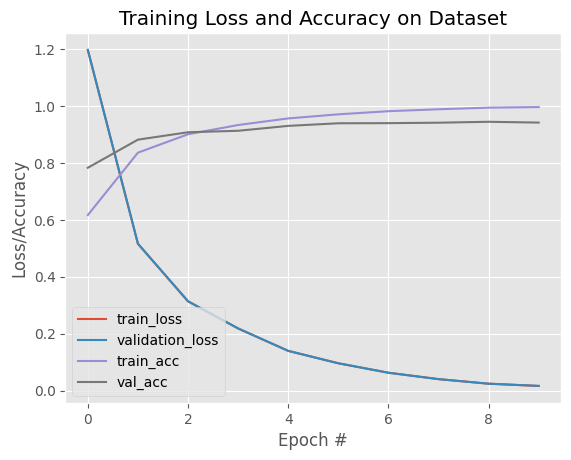

In [58]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="validation_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")